In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential

Anadimos si tenemos GPU para entrenar. En mi caso si tengo una GPU.

In [2]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

In [3]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Inspecion de datos

A continuacion cargamos los datos

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
X_train_full.shape

(60000, 28, 28)

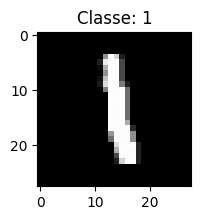

In [6]:
def show_example(id):
    plt.figure(figsize=(2, 2)) # Hacemos que la fotografia se vea mas pquena
    plt.imshow(X_train_full[id], cmap='gray')
    plt.title(f"Classe: {y_train_full[id]}")
    plt.show()

show_example(6)

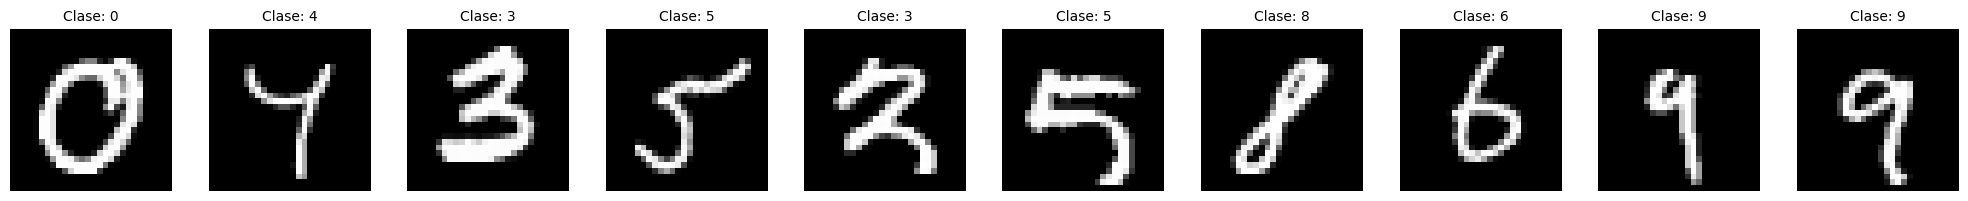

In [7]:
import random

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Pick random values from dataset
    random_value_from_dataset = random.randint(0, X_train_full.shape[0])
    ax = axes[i]
    ax.imshow(X_train_full[random_value_from_dataset], cmap='gray', interpolation='nearest')
    ax.set_title(f"Clase: {y_train_full[random_value_from_dataset]}", fontsize=10)
    ax.axis('off')  # Ocultar los ejes
plt.tight_layout()
plt.show()

In [8]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Podemos ver que ahora que el titulo es asi

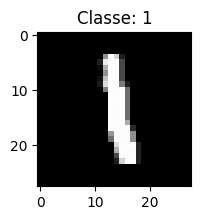

In [9]:
show_example(6)

# Ejemplo del Libro

In [10]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [11]:
def clean_session():
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
clean_session()

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

2024-10-17 22:22:25.875350: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-17 22:22:25.875376: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-17 22:22:25.875382: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-17 22:22:25.875431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-17 22:22:25.875448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",               
              optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [14]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

  10/1719 [..............................] - ETA: 9s - loss: 2.4223 - accuracy: 0.1562  

2024-10-17 22:22:26.249795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5035

2024-10-17 22:22:35.804111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.5035 - val_loss: nan - val_accuracy: 0.0958


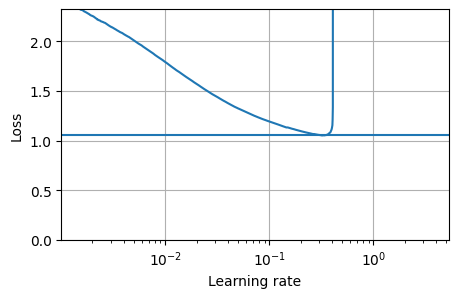

In [15]:
def view_learning_rate(expon_lr_default):
    plt.figure(figsize=(5, 3))
    plt.plot(expon_lr_default.rates, expon_lr_default.losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(expon_lr_default.losses), min(expon_lr_default.rates), max(expon_lr_default.rates))
    plt.axis([min(expon_lr_default.rates), max(expon_lr_default.rates), 0, expon_lr_default.losses[0]])
    plt.grid()
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

view_learning_rate(expon_lr)

# Apartado 1
Hay que construir redes con al menos 3 y 4 capas ocultas.

## Red con 3 capas ocultas

In [16]:
tf.keras.backend.clear_session()

2024-10-17 22:23:54.071506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4757

2024-10-17 22:24:06.436123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 13s 7ms/step - loss: nan - accuracy: 0.4757 - val_loss: nan - val_accuracy: 0.0958
[0.0010050000477349384, 0.0010100250859977676, 0.0010150751617038622, 0.001020150508848019, 0.0010252512444276361, 0.0010303774854401124, 0.0010355293488828463, 0.0010407069517532363, 0.0010459105280460788, 0.0010511400777613743, 0.0010563958348939193, 0.0010616777994437142, 0.0010669862054055556, 0.0010723211697768419, 0.0010776828095549716, 0.0010830712417373432, 0.0010884865833213552, 0.0010939290683018043, 0.0010993986966786906, 0.0011048957024468108, 0.0011104202026035635, 0.0011159723141463472, 0.0011215521540725603, 0.0011271599563769995, 0.001132795721059665, 0.0011384596821153534, 0.0011441519565414636, 0.0011498726613353937, 0.0011556220304919406, 0.0011614001810085028, 0.0011672072298824787, 0.0011730432941112665, 0.0011789084906922652, 0.0011848030536202713, 0.0011907270998926832, 0.0011966807465068994, 0.0012026641104603184, 0.0012086774257477372,

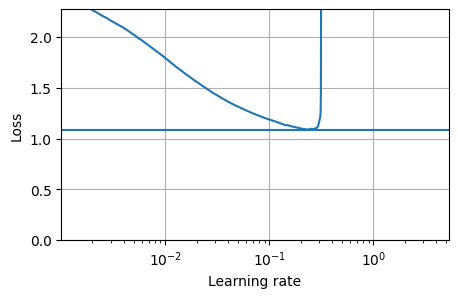

In [27]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_3 = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3)
model_3.compile(loss="sparse_categorical_crossentropy",               
              optimizer=optimizer_3,
              metrics=["accuracy"])
expon_lr_3 = ExponentialLearningRate(factor=1.005)
history = model_3.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr_3])
print(expon_lr_3.rates)
print(expon_lr_3.losses[0])
view_learning_rate(expon_lr_3)

## Red con 4 capas ocultas

In [28]:
tf.keras.backend.clear_session()

In [33]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [34]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3)
model_4.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr_4 = ExponentialLearningRate(factor=1.001)

In [35]:
history_4 = model_4.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr_4])

   9/1719 [..............................] - ETA: 10s - loss: 2.4976 - accuracy: 0.1285 

2024-10-17 22:25:23.507399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1718/1719 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.2376

2024-10-17 22:25:34.638456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 12s 7ms/step - loss: nan - accuracy: 0.2375 - val_loss: nan - val_accuracy: 0.0958


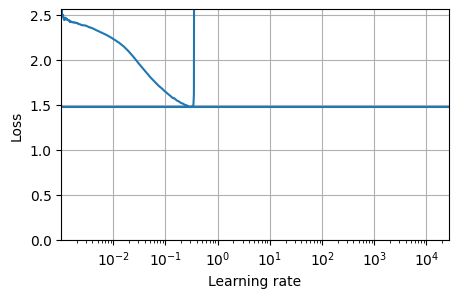

In [36]:
view_learning_rate(expon_lr_4)